In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.offline as pyo

from sklearn.model_selection import train_test_split, KFold, cross_validate, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import VotingClassifier

import eli5 # Feature importance evaluation

pd.options.display.max_columns = 20
pd.options.display.max_rows = 20

C:\Users\frank\Anaconda3\envs\pytorch\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning:

The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.



In [2]:
df = pd.read_csv('C:\\Users\\frank\\OneDrive\\Desktop\\Kaggle\\data\\hotel_bookings.csv')
df.head()

hotel  is_canceled  lead_time  arrival_date_year arrival_date_month  \
0  Resort Hotel            0        342               2015               July   
1  Resort Hotel            0        737               2015               July   
2  Resort Hotel            0          7               2015               July   
3  Resort Hotel            0         13               2015               July   
4  Resort Hotel            0         14               2015               July   

   arrival_date_week_number  arrival_date_day_of_month  \
0                        27                          1   
1                        27                          1   
2                        27                          1   
3                        27                          1   
4                        27                          1   

   stays_in_weekend_nights  stays_in_week_nights  adults  ...  deposit_type  \
0                        0                     0       2  ...    No Deposit   
1                        0                     0       2  ...    No Deposit   
2                        0                     1       1  ...    No Deposit   
3                        0                     1       1  ...    No Deposit   
4                        0                     2       2  ...    No Deposit   

   agent company days_in_waiting_list customer_type   adr  \
0    NaN     NaN                    0     Transient   0.0   
1    NaN     NaN                    0     Transient   0.0   
2    NaN     NaN                    0     Transient  75.0   
3  304.0     NaN                    0     Transient  75.0   
4  240.0     NaN                    0     Transient  98.0   

   required_car_parking_spaces  total_of_special_requests  reservation_status  \
0                            0                          0           Check-Out   
1                            0                          0           Check-Out   
2                            0                          0           Check-Out   
3                            0                          0           Check-Out   
4                            0                          1           Check-Out   

  reservation_status_date  
0              2015-07-01  
1              2015-07-01  
2              2015-07-02  
3              2015-07-02  
4              2015-07-03  

[5 rows x 32 columns]

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

# Data Cleaning

In [4]:
df['hotel'].value_counts()

City Hotel      79330
Resort Hotel    40060
Name: hotel, dtype: int64

In [5]:
df.isnull().sum()[df.isnull().sum() > 0]

children         4
country        488
agent        16340
company     112593
dtype: int64

In [6]:
nan_replacements = {"children": 0.0,"country": "Unknown", "agent": 0, "company": 0}

df_cln = df.fillna(nan_replacements)
df_cln['meal'].replace("Undefined", "SC", inplace = True)

zero_guests = list(df[(df_cln['adults'] + df_cln['children'] + df_cln['babies']) == 0].index)

df_cln.drop(df_cln.index[zero_guests], inplace = True)
df_cln = df_cln.reset_index(drop = True)

In [7]:
df_cln.shape

(119210, 32)

In [8]:
df_cln.isnull().sum()[df_cln.isnull().sum() > 0]

Series([], dtype: int64)

In [9]:
df_cln[df_cln.isnull()['children']]['children']

Series([], Name: children, dtype: float64)

# EDA

In [10]:
df_rh = df_cln[(df_cln['hotel'] == 'Resort Hotel') & (df_cln['is_canceled'] == 0)]
df_ch = df_cln[(df_cln['hotel'] == 'City Hotel') & (df_cln['is_canceled'] == 0)]

In [11]:
print(df_rh.shape)
print(df_ch.shape)

(28927, 32)
(46084, 32)


## Guests by Countries

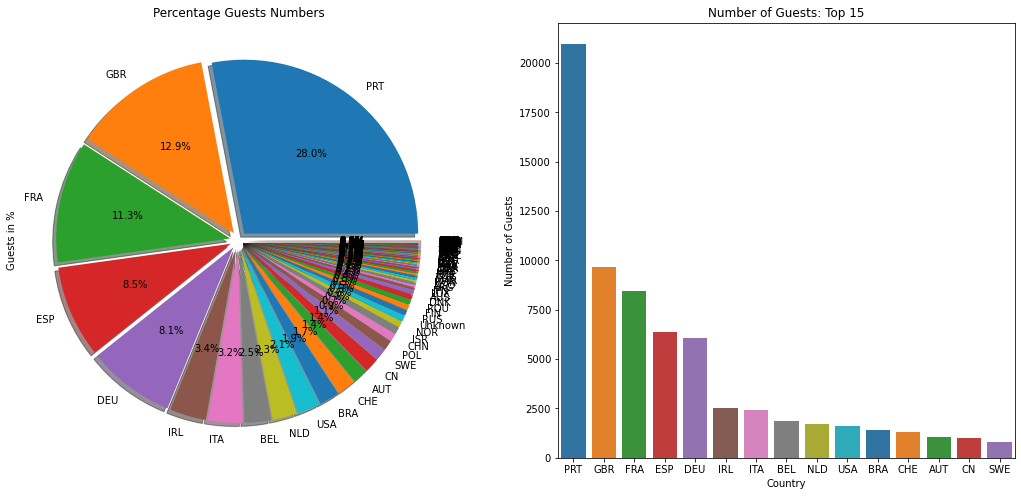

In [12]:
country_data = pd.DataFrame(df_cln[df_cln['is_canceled'] == 0]['country'].value_counts()).reset_index()
country_data.columns = ['Country', 'Number of Guests']
total_guests = country_data['Number of Guests'].sum()
country_data["Guests in %"] = round(country_data["Number of Guests"] / total_guests * 100, 2)
country_data["country"] = country_data.index

#Pie plot
f, ax=plt.subplots(1,2,figsize=(18,8))
country_data["Guests in %"].plot.pie(explode = [0.05] * len(country_data), autopct='%1.1f%%',shadow=True, labels = country_data['Country'], ax = ax[0])
ax[0].set_title('Percentage Guests Numbers')
ax[1] = sns.barplot(x = country_data['Country'][:15], y = country_data['Number of Guests'][:15], palette = 'tab10')
ax[1].set_title('Number of Guests: Top 15')
plt.show()

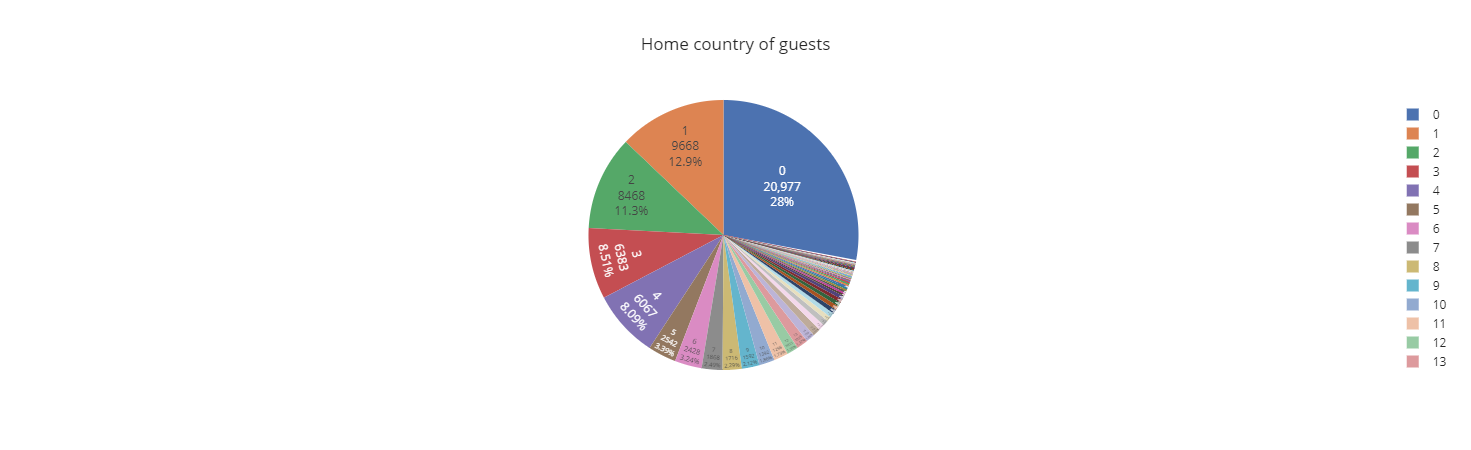

In [13]:
fig = px.pie(country_data,
             values="Number of Guests",
             names="country",
             title="Home country of guests",
             template="seaborn")
fig.update_traces(textposition="inside", textinfo="value+percent+label")
fig.show()

## Guests by Countries Worldmap

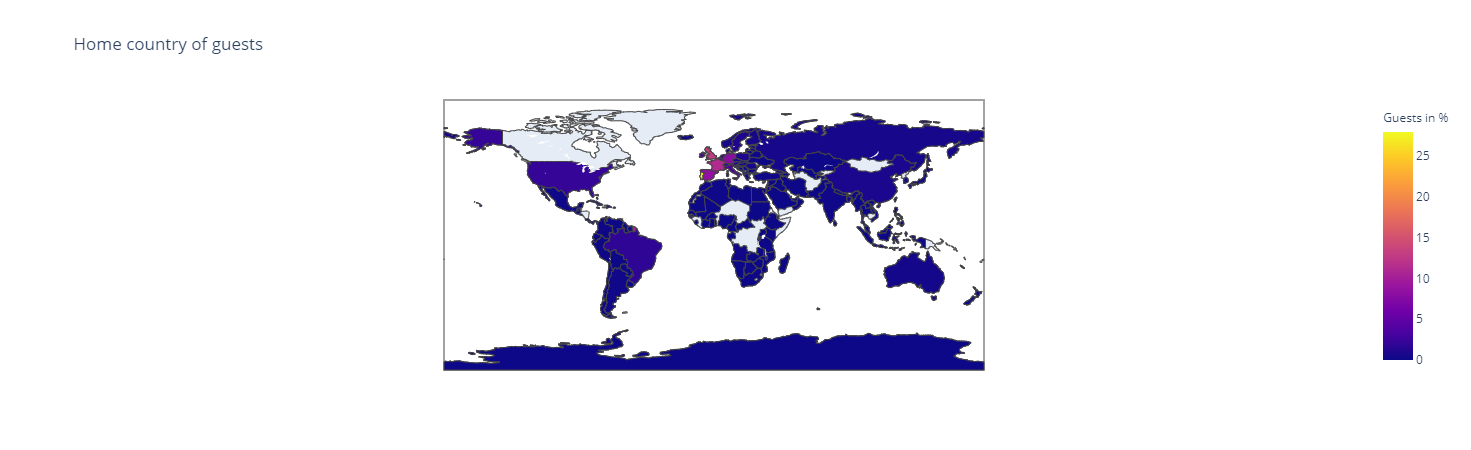

In [14]:
# show on map
guest_map = px.choropleth(country_data,
                    locations=country_data['Country'],
                    color=country_data["Guests in %"], 
                    hover_name=country_data.index, 
                    color_continuous_scale=px.colors.sequential.Plasma,
                    title="Home country of guests")
guest_map.show()

## How much do guests pay for a room per night?

In [15]:
df_rh.loc[:, "adr_pp"] = df_rh.loc[:, "adr"] / (df_rh.loc[:, "adults"] + df_rh.loc[:, "children"])
df_ch.loc[:, "adr_pp"] = df_ch.loc[:, "adr"] / (df_ch.loc[:, "adults"] + df_ch.loc[:, "children"])
print("""From all non-cnceled bookings, across all room types and meals, the average prices are:
Resort hotel: {:.2f} € per night and person.
City hotel: {:.2f} € per night and person."""
      .format(df_rh.loc[:, "adr_pp"].mean(), df_ch.loc[:, "adr_pp"].mean()))

From all non-cnceled bookings, across all room types and meals, the average prices are:
Resort hotel: 47.49 € per night and person.
City hotel: 59.27 € per night and person.


C:\Users\frank\Anaconda3\envs\pytorch\lib\site-packages\pandas\core\indexing.py:844: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\frank\Anaconda3\envs\pytorch\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



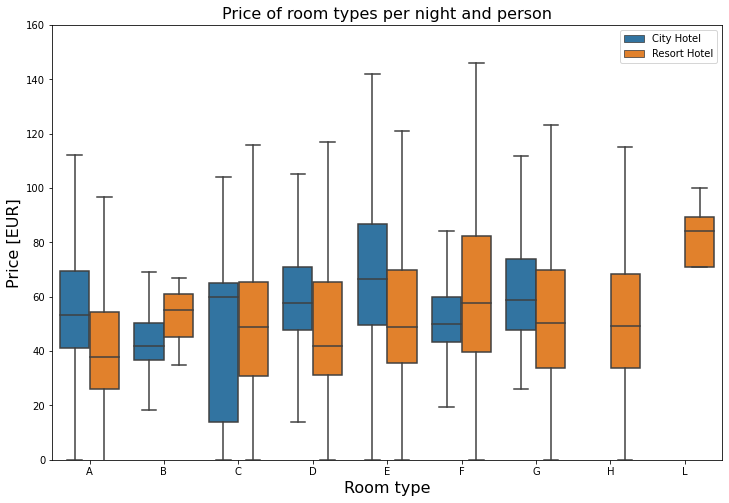

In [16]:
# normalize price per night (adr):
df_cln["adr_pp"] = df_cln["adr"] / (df_cln["adults"] + df_cln["children"])
df_guests = df_cln.loc[df_cln["is_canceled"] == 0] # only actual gusts
room_prices = df_guests[["hotel", "reserved_room_type", "adr_pp"]].sort_values("reserved_room_type")

# boxplot:
plt.figure(figsize=(12, 8))
sns.boxplot(x="reserved_room_type",
            y="adr_pp",
            hue="hotel",
            data=room_prices, 
            hue_order=["City Hotel", "Resort Hotel"],
            fliersize=0)

plt.title("Price of room types per night and person", fontsize=16)
plt.xlabel("Room type", fontsize=16)
plt.ylabel("Price [EUR]", fontsize=16)
plt.legend(loc="upper right")
plt.ylim(0, 160)
plt.show()

## How does the price per night vary over the year?

In [17]:
# grab data:
room_prices_mothly = df_guests[["hotel", "arrival_date_month", "adr_pp"]].sort_values("arrival_date_month")

# order by month:
ordered_months = ["January", "February", "March", "April", "May", "June", 
          "July", "August", "September", "October", "November", "December"]
room_prices_mothly["arrival_date_month"] = pd.Categorical(room_prices_mothly["arrival_date_month"], categories=ordered_months, ordered=True)

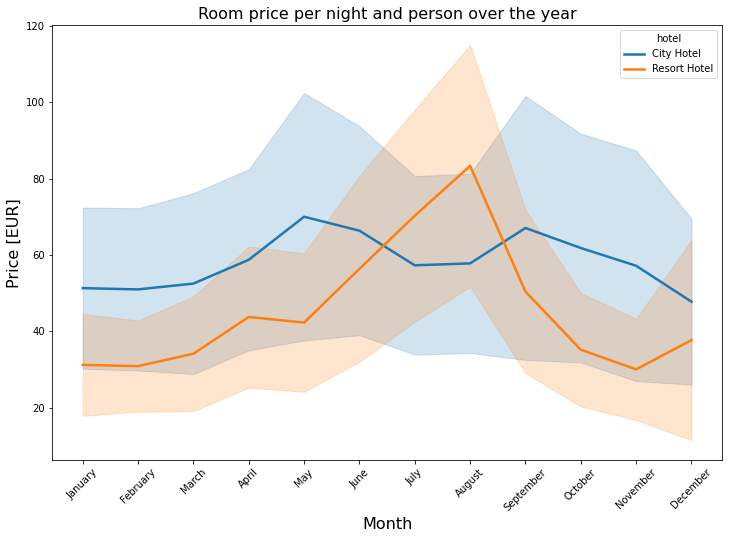

In [18]:
# barplot with standard deviation:
plt.figure(figsize=(12, 8))
sns.lineplot(x = "arrival_date_month", y="adr_pp", hue="hotel", data=room_prices_mothly, 
            hue_order = ["City Hotel", "Resort Hotel"], ci="sd", size="hotel", sizes=(2.5, 2.5))
plt.title("Room price per night and person over the year", fontsize=16)
plt.xlabel("Month", fontsize=16)
plt.xticks(rotation=45)
plt.ylabel("Price [EUR]", fontsize=16)
plt.show()

## When are the busiest months?

In [19]:
# Create a DateFrame with the relevant data:
resort_guests_monthly = df_rh.groupby("arrival_date_month").size()
city_guests_monthly = df_ch.groupby("arrival_date_month").size()

resort_guest_data = pd.DataFrame({"month": list(resort_guests_monthly.index),
                    "hotel": "Resort hotel", 
                    "guests": list(resort_guests_monthly.values)})

city_guest_data = pd.DataFrame({"month": list(city_guests_monthly.index),
                    "hotel": "City hotel", 
                    "guests": list(city_guests_monthly.values)})
full_guest_data = pd.concat([resort_guest_data,city_guest_data], ignore_index=True)

# order by month:
ordered_months = ["January", "February", "March", "April", "May", "June", 
          "July", "August", "September", "October", "November", "December"]

full_guest_data["month"] = pd.Categorical(full_guest_data["month"], categories=ordered_months, ordered=True)

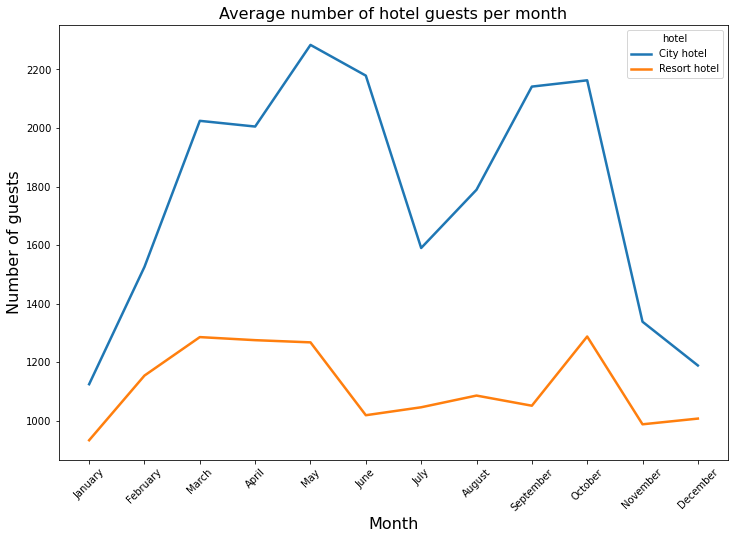

In [20]:
# Dataset contains July and August date from 3 years, the other month from 2 years. Normalize data:
full_guest_data.loc[(full_guest_data["month"] == "July") | (full_guest_data["month"] == "August"),
                    "guests"] /= 3
full_guest_data.loc[~((full_guest_data["month"] == "July") | (full_guest_data["month"] == "August")),
                    "guests"] /= 2

#show figure:
plt.figure(figsize=(12, 8))
sns.lineplot(x = "month", y="guests", hue="hotel", data=full_guest_data, 
             hue_order = ["City hotel", "Resort hotel"], size="hotel", sizes=(2.5, 2.5))
plt.title("Average number of hotel guests per month", fontsize=16)
plt.xlabel("Month", fontsize=16)
plt.xticks(rotation=45)
plt.ylabel("Number of guests", fontsize=16)
plt.show()

## How long do people stay at the hotels?

In [21]:
# Create a DateFrame with the relevant data:
#df_rh.loc[:, "total_nights"] = df_rh.loc[:, "stays_in_weekend_nights"] + df_rh.loc[:, "stays_in_week_nights"]
df_rh.loc[:, "total_nights"] = df_rh["stays_in_weekend_nights"] + df_rh["stays_in_week_nights"]
df_ch.loc[:, "total_nights"] = df_ch["stays_in_weekend_nights"] + df_ch["stays_in_week_nights"]

C:\Users\frank\Anaconda3\envs\pytorch\lib\site-packages\pandas\core\indexing.py:844: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\frank\Anaconda3\envs\pytorch\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [22]:
num_nights_res = list(df_rh["total_nights"].value_counts().index)
num_bookings_res = list(df_rh["total_nights"].value_counts())
rel_bookings_res = df_rh["total_nights"].value_counts() / sum(num_bookings_res) * 100

In [23]:
num_nights_cty = list(df_ch["total_nights"].value_counts().index)
num_bookings_cty = list(df_ch["total_nights"].value_counts())
rel_bookings_cty = df_ch["total_nights"].value_counts() / sum(num_bookings_cty) * 100

In [24]:
res_nights = pd.DataFrame({"hotel": "Resort hotel",
                           "num_nights": num_nights_res,
                           "rel_num_bookings": rel_bookings_res})

cty_nights = pd.DataFrame({"hotel": "City hotel",
                           "num_nights": num_nights_cty,
                           "rel_num_bookings": rel_bookings_cty})

nights_data = pd.concat([res_nights, cty_nights], ignore_index=True)

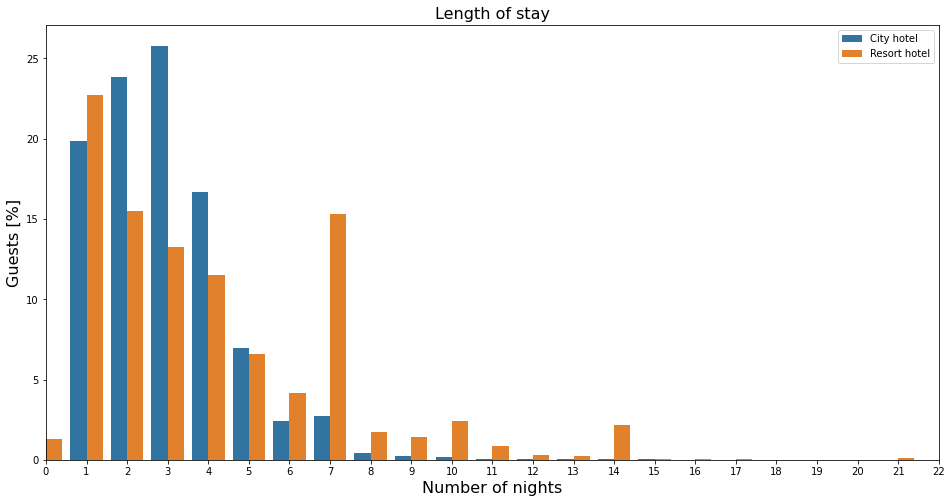

In [25]:
#show figure:
plt.figure(figsize=(16, 8))
sns.barplot(x = "num_nights", y = "rel_num_bookings", hue="hotel", data=nights_data,
            hue_order = ["City hotel", "Resort hotel"])
plt.title("Length of stay", fontsize=16)
plt.xlabel("Number of nights", fontsize=16)
plt.ylabel("Guests [%]", fontsize=16)
plt.legend(loc="upper right")
plt.xlim(0,22)
plt.show()

In [26]:
avg_nights_res = sum(list((res_nights["num_nights"] * (res_nights["rel_num_bookings"]/100)).values))
avg_nights_cty = sum(list((cty_nights["num_nights"] * (cty_nights["rel_num_bookings"]/100)).values))
print(f"On average, guests of the City hotel stay {avg_nights_cty:.2f} nights, and {cty_nights['num_nights'].max()} at maximum.")
print(f"On average, guests of the Resort hotel stay {avg_nights_res:.2f} nights, and {res_nights['num_nights'].max()} at maximum.")

On average, guests of the City hotel stay 2.92 nights, and 48 at maximum.
On average, guests of the Resort hotel stay 4.14 nights, and 69 at maximum.


## Bookings by market segment

In [27]:
segments = df_cln['market_segment'].value_counts()

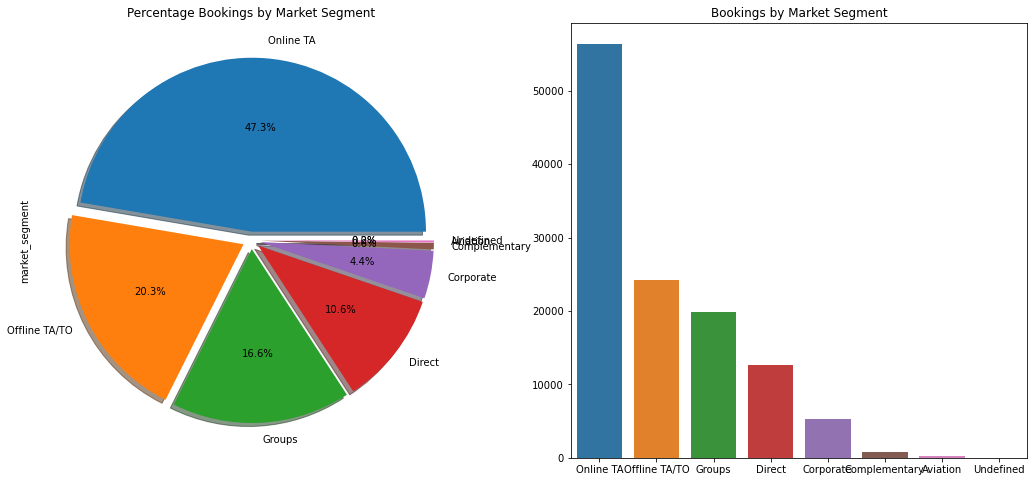

In [28]:
#Pie plot
f, ax=plt.subplots(1,2,figsize=(18,8))
segments.plot.pie(explode = [0.05] * len(segments), autopct='%1.1f%%',shadow=True, labels = segments.index, ax = ax[0])
ax[0].set_title('Percentage Bookings by Market Segment')
ax[1] = sns.barplot(x = segments.index, y = segments.values, palette = 'tab10')
ax[1].set_title('Bookings by Market Segment')
plt.show()

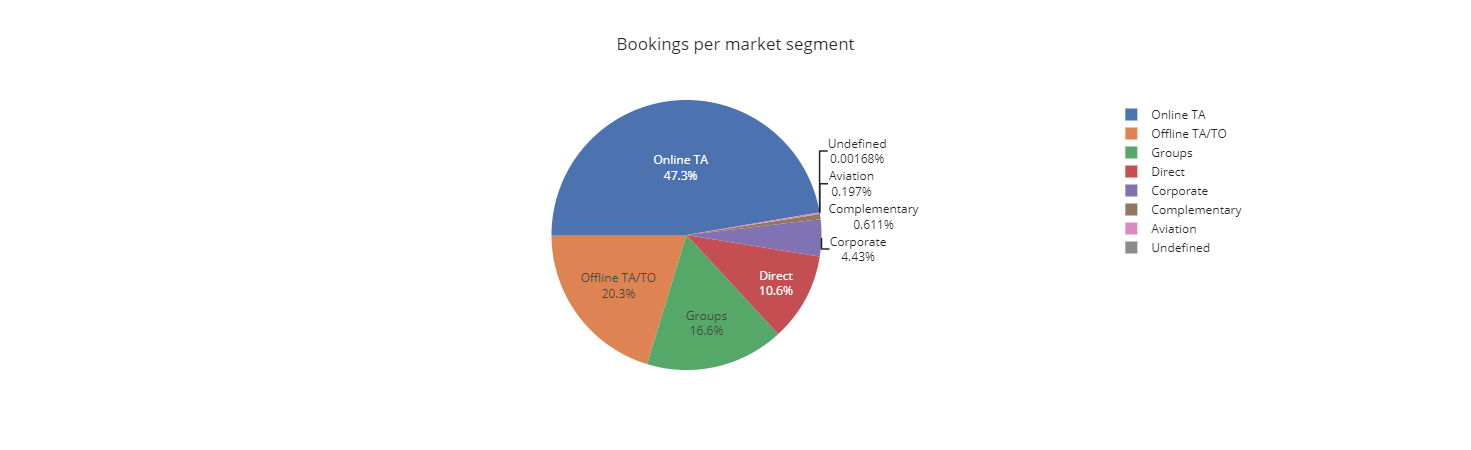

In [29]:
# pie plot
fig = px.pie(segments,
             values=segments.values,
             names=segments.index,
             title="Bookings per market segment",
             template="seaborn")
fig.update_traces(rotation=-90, textinfo="percent+label")
fig.show()

## price per night (ADR) and person based on booking and room.

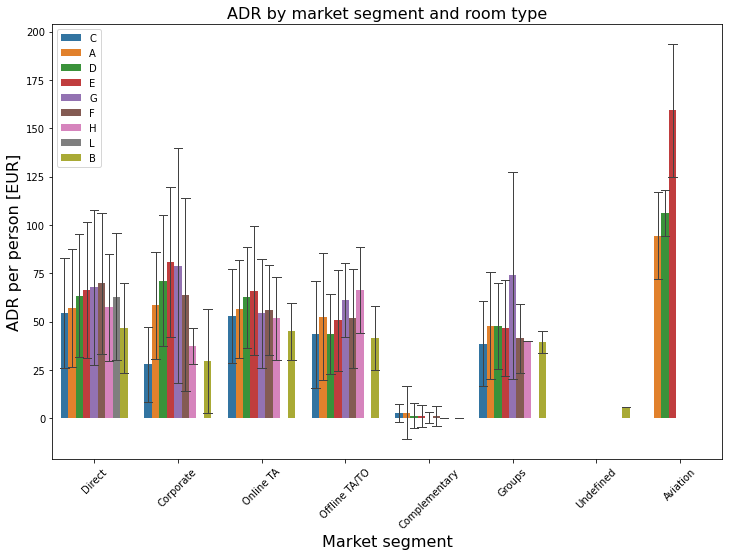

In [30]:
plt.figure(figsize=(12, 8))
sns.barplot(x="market_segment",
            y="adr_pp",
            hue="reserved_room_type",
            data=df_cln,
            ci="sd",
            errwidth=1,
            capsize=0.1)
plt.title("ADR by market segment and room type", fontsize=16)
plt.xlabel("Market segment", fontsize=16)
plt.xticks(rotation=45)
plt.ylabel("ADR per person [EUR]", fontsize=16)
plt.legend(loc="upper left")
plt.show()

In [31]:
# Summarize Relevant data:
Airline_data = df_cln.loc[df_cln["market_segment"]== "Aviation"][["is_canceled",
                                                                                "adults",
                                                                                "lead_time",
                                                                                "adr_pp",]].describe()

Non_Airline_data = df_cln.loc[df_cln["market_segment"]!= "Aviation"][["is_canceled",
                                                                                    "adults",
                                                                                    "lead_time",
                                                                                    "adr_pp",]].describe()

In [32]:
Airline_data

is_canceled      adults  lead_time      adr_pp
count   235.000000  235.000000  235.00000  235.000000
mean      0.221277    1.012766    4.47234  100.270979
std       0.415992    0.112503    4.61629   20.376689
min       0.000000    1.000000    0.00000    0.000000
25%       0.000000    1.000000    1.00000   95.000000
50%       0.000000    1.000000    3.00000   95.000000
75%       0.000000    1.000000    6.00000  110.000000
max       1.000000    2.000000   23.00000  193.500000

In [33]:
Non_Airline_data

is_canceled         adults      lead_time         adr_pp
count  118975.000000  118975.000000  118975.000000  118975.000000
mean        0.371061       1.860878     104.306031      55.036835
std         0.483091       0.574499     106.888885      29.017596
min         0.000000       0.000000       0.000000      -3.190000
25%         0.000000       2.000000      18.000000      37.440000
50%         0.000000       2.000000      69.000000      49.500000
75%         1.000000       2.000000     161.000000      66.000000
max         1.000000      55.000000     737.000000    2700.000000

- Lead time for bookings from Aviation is very short: Mean 4 days vs. 104 days for other bookings.
- Airlines NEED a place for their crews to stay.
- Airline personel usually gets one room per person - more total rooms required compared to families.

## How many bookings were canceled

In [34]:
# absolute cancelations:
total_cancelations = df_cln["is_canceled"].sum()
rh_cancelations = df_cln.loc[df_cln["hotel"] == "Resort Hotel"]["is_canceled"].sum()
ch_cancelations = df_cln.loc[df_cln["hotel"] == "City Hotel"]["is_canceled"].sum()

# as percent:
rel_cancel = total_cancelations / df_cln.shape[0] * 100
rh_rel_cancel = rh_cancelations / df_cln.loc[df_cln["hotel"] == "Resort Hotel"].shape[0] * 100
ch_rel_cancel = ch_cancelations / df_cln.loc[df_cln["hotel"] == "City Hotel"].shape[0] * 100

print(f"Total bookings canceled: {total_cancelations:,} ({rel_cancel:.0f} %)")
print(f"Resort hotel bookings canceled: {rh_cancelations:,} ({rh_rel_cancel:.0f} %)")
print(f"City hotel bookings canceled: {ch_cancelations:,} ({ch_rel_cancel:.0f} %)")

Total bookings canceled: 44,199 (37 %)
Resort hotel bookings canceled: 11,120 (28 %)
City hotel bookings canceled: 33,079 (42 %)


## Which month have the highest number of cancelations

In [35]:
# Create a DateFrame with the relevant data:
res_book_per_month = df_cln.loc[(df_cln["hotel"] == "Resort Hotel")].groupby("arrival_date_month")["hotel"].count()
res_cancel_per_month = df_cln.loc[(df_cln["hotel"] == "Resort Hotel")].groupby("arrival_date_month")["is_canceled"].sum()

cty_book_per_month = df_cln.loc[(df_cln["hotel"] == "City Hotel")].groupby("arrival_date_month")["hotel"].count()
cty_cancel_per_month = df_cln.loc[(df_cln["hotel"] == "City Hotel")].groupby("arrival_date_month")["is_canceled"].sum()

res_cancel_data = pd.DataFrame({"Hotel": "Resort Hotel",
                                "Month": list(res_book_per_month.index),
                                "Bookings": list(res_book_per_month.values),
                                "Cancelations": list(res_cancel_per_month.values)})
cty_cancel_data = pd.DataFrame({"Hotel": "City Hotel",
                                "Month": list(cty_book_per_month.index),
                                "Bookings": list(cty_book_per_month.values),
                                "Cancelations": list(cty_cancel_per_month.values)})

full_cancel_data = pd.concat([res_cancel_data, cty_cancel_data], ignore_index=True)
full_cancel_data["cancel_percent"] = full_cancel_data["Cancelations"] / full_cancel_data["Bookings"] * 100

# order by month:
ordered_months = ["January", "February", "March", "April", "May", "June", 
          "July", "August", "September", "October", "November", "December"]
full_cancel_data["Month"] = pd.Categorical(full_cancel_data["Month"], categories=ordered_months, ordered=True)

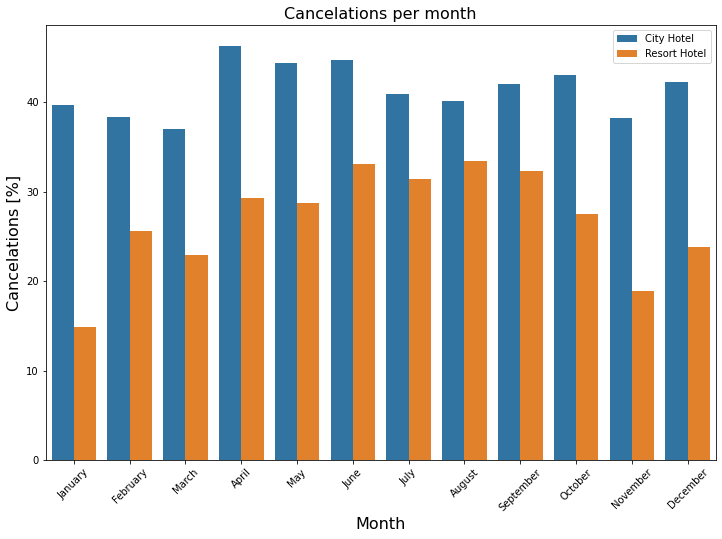

In [36]:
# show figure:
plt.figure(figsize=(12, 8))
sns.barplot(x = "Month", y = "cancel_percent" , hue="Hotel",
            hue_order = ["City Hotel", "Resort Hotel"], data=full_cancel_data)
plt.title("Cancelations per month", fontsize=16)
plt.xlabel("Month", fontsize=16)
plt.xticks(rotation=45)
plt.ylabel("Cancelations [%]", fontsize=16)
plt.legend(loc="upper right")
plt.show()

- For the City hotel the relative number of cancelations is around 40 % throughout the year.
- For the Resort hotel it is highest in the summer and lowest during the winter.

# Predict Cancelations

In [37]:
cancel_corr = df.corr()["is_canceled"]
cancel_corr.abs().sort_values(ascending=False)[1:]

lead_time                         0.293123
total_of_special_requests         0.234658
required_car_parking_spaces       0.195498
booking_changes                   0.144381
previous_cancellations            0.110133
is_repeated_guest                 0.084793
agent                             0.083114
adults                            0.060017
previous_bookings_not_canceled    0.057358
days_in_waiting_list              0.054186
adr                               0.047557
babies                            0.032491
stays_in_week_nights              0.024765
company                           0.020642
arrival_date_year                 0.016660
arrival_date_week_number          0.008148
arrival_date_day_of_month         0.006130
children                          0.005048
stays_in_weekend_nights           0.001791
Name: is_canceled, dtype: float64

From this list it is apparent that lead_time, total_of_special_requests, required_car_parking_spaces, booking_changes and previous_cancellations are the 5 most important numerical features.

However, to predict wheater or not a booking will be canceled, the number of booking changes is a possible source of leakage, because this information can change over time.

I will also not include days_in_waiting_list and arrival_date_year.

In [38]:
# The most important feature to exclude is the "reservation_status":

df.groupby("is_canceled")["reservation_status"].value_counts()

is_canceled  reservation_status
0            Check-Out             75166
1            Canceled              43017
             No-Show                1207
Name: reservation_status, dtype: int64

## Comparing different base models

In [39]:
# The category "reservation_status_data" seems to correlate with "reservation_status". Including below information will increase the accuracy greatly, but need to exclude from the data as "reservation_status".

df_cln['reservation_status_date'] = pd.to_datetime(df_cln['reservation_status_date'])

df_cln['year'] = df_cln['reservation_status_date'].dt.year
df_cln['month'] = df_cln['reservation_status_date'].dt.month
df_cln['day'] = df_cln['reservation_status_date'].dt.day


In [40]:
# manually choose columns to include
# some columns are excluded to make the model more general and to prevent leakage
# (arrival_date_year, assigned_room_type, booking_changes, reservation_status, country,
# days_in_waiting_list)
# including the country would increase accuracy, but it may also make the model less general

num_features = ["lead_time","arrival_date_week_number","arrival_date_day_of_month",
                "stays_in_weekend_nights","stays_in_week_nights","adults","children",
                "babies","is_repeated_guest", "previous_cancellations",
                "previous_bookings_not_canceled","agent","company",
                "required_car_parking_spaces", "total_of_special_requests", "adr"]

cat_features = ["hotel", 'arrival_date_month', "meal","market_segment",
                "distribution_channel","reserved_room_type","deposit_type","customer_type"]

# Separate features and predicted value
features = num_features + cat_features
X = df_cln.drop(["is_canceled"], axis=1)[features]
y = df_cln["is_canceled"]

In [41]:
# preprocess numerical feats:
# for most num cols, except the dates, 0 is the most logical choice as fill value
# and here no dates are missing.
num_transformer = SimpleImputer(strategy="constant")

# Preprocessing for categorical features:
cat_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="Unknown")),
    ("onehot", OneHotEncoder(handle_unknown='ignore'))])

# Bundle preprocessing for numerical and categorical features:
preprocessor = ColumnTransformer(transformers=[("num", num_transformer, num_features),
                                               ("cat", cat_transformer, cat_features)])

In [42]:
# define models to test:
base_models = [("DT_model", DecisionTreeClassifier(random_state=42)),
               ("RF_model", RandomForestClassifier(random_state=42,n_jobs=-1)),
               ("LR_model", LogisticRegression(random_state=42,n_jobs=-1)),
               ("XGB_model", XGBClassifier(random_state=42, n_jobs=-1))]

In [43]:
# split data into 'kfolds' parts for cross validation,
# use shuffle to ensure random distribution of data:
kfolds = 4 # 4 = 75% train, 25% validation
split = KFold(n_splits=kfolds, shuffle=True, random_state=42)

In [44]:
# define models to test:
base_models = [("DT_model", DecisionTreeClassifier(random_state=42)),
               ("RF_model", RandomForestClassifier(random_state=42,n_jobs=-1)),
               ("LR_model", LogisticRegression(random_state=42,n_jobs=-1)),
               ("XGB_model", XGBClassifier(random_state=42, n_jobs=-1))]

# split data into 'kfolds' parts for cross validation,
# use shuffle to ensure random distribution of data:
kfolds = 4 # 4 = 75% train, 25% validation
split = KFold(n_splits=kfolds, shuffle=True, random_state=42)

# Preprocessing, fitting, making predictions and scoring for every model:
for name, model in base_models:
    # pack preprocessing of data and the model in a pipeline:
    model_steps = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)])
    
    # get cross validation score for each model:
    cv_results = cross_val_score(model_steps, 
                                 X, y, 
                                 cv=split,
                                 scoring="accuracy",
                                 n_jobs=-1)
    # output:
    min_score = round(min(cv_results), 4)
    max_score = round(max(cv_results), 4)
    mean_score = round(np.mean(cv_results), 4)
    std_dev = round(np.std(cv_results), 4)
    print(f"{name} cross validation accuarcy score: {mean_score} +/- {std_dev} (std) min: {min_score}, max: {max_score}")
    
    #pipeline.fit(X_train, y_train)
    #preds = pipeline.predict(X_valid)
    #score = accuracy_score(y_valid, preds)
    #print(f"{name} accuracy_score: {round(score, 4)}")
    

DT_model cross validation accuarcy score: 0.8259 +/- 0.0008 (std) min: 0.8248, max: 0.827
RF_model cross validation accuarcy score: 0.8667 +/- 0.0008 (std) min: 0.8659, max: 0.8681
LR_model cross validation accuarcy score: 0.7942 +/- 0.003 (std) min: 0.7913, max: 0.798
XGB_model cross validation accuarcy score: 0.8468 +/- 0.0011 (std) min: 0.8455, max: 0.8483


The RandomForest model performs best.

In [46]:
# Enhanced RF model with the best parameters I found:
rf_model_enh = RandomForestClassifier(n_estimators=160,
                               max_features=0.4,
                               min_samples_split=2,
                               n_jobs=-1,
                               random_state=0)

split = KFold(n_splits=kfolds, shuffle=True, random_state=42)
model_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', rf_model_enh)])
cv_results = cross_val_score(model_pipe, 
                                 X, y, 
                                 cv=split,
                                 scoring="accuracy",
                                 n_jobs=-1)
# output:
min_score = round(min(cv_results), 4)
max_score = round(max(cv_results), 4)
mean_score = round(np.mean(cv_results), 4)
std_dev = round(np.std(cv_results), 4)
print(f"Enhanced RF model cross validation accuarcy score: {mean_score} +/- {std_dev} (std) min: {min_score}, max: {max_score}")

Enhanced RF model cross validation accuarcy score: 0.8676 +/- 0.0009 (std) min: 0.8664, max: 0.8684


# Evaluate Feature Importance using eli5

In [47]:
# fit model(pipeline) so values can be accessed:
model_pipe.fit(X,y)

# Names of all (encoded) features are needed.
# Get names of columns from One Hot Encoding:
onehot_columns = list(model_pipe.named_steps['preprocessor'].
                      named_transformers_['cat'].
                      named_steps['onehot'].
                      get_feature_names(input_features=cat_features))

In [48]:
# Add num_features for full list.
# Order must be as in definition of X, where num_features are first: 
feat_imp_list = num_features + onehot_columns

# show 10 most important features, provide names of features:
feat_imp_df = eli5.formatters.as_dataframe.explain_weights_df(
    model_pipe.named_steps['model'],
    feature_names=feat_imp_list)
feat_imp_df.head(10)

feature    weight       std
0                  lead_time  0.146662  0.015429
1    deposit_type_Non Refund  0.144410  0.104293
2                        adr  0.095883  0.003540
3  arrival_date_day_of_month  0.069530  0.002063
4    deposit_type_No Deposit  0.068087  0.099340
5   arrival_date_week_number  0.053693  0.002527
6  total_of_special_requests  0.050826  0.011110
7                      agent  0.042553  0.005336
8       stays_in_week_nights  0.041500  0.002232
9     previous_cancellations  0.040826  0.014164

Looking at the three most important features:
- lead_time
- deposit_type
- adr

## Lead_time

In [49]:
# group data for lead_time:
lead_cancel_data = df_cln.groupby("lead_time")["is_canceled"].describe()
# use only lead_times wih more than 10 bookings for graph:
lead_cancel_data_10 = lead_cancel_data.loc[lead_cancel_data["count"] >= 10]

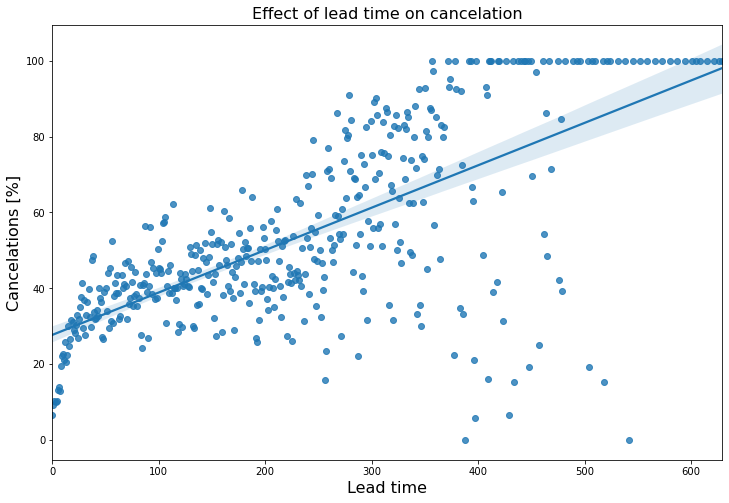

In [50]:
#show figure:
plt.figure(figsize=(12, 8))
sns.regplot(x=lead_cancel_data_10.index, y=lead_cancel_data_10["mean"].values * 100, ci = 95, order = 1)
plt.title("Effect of lead time on cancelation", fontsize=16)
plt.xlabel("Lead time", fontsize=16)
plt.ylabel("Cancelations [%]", fontsize=16)
# plt.xlim(0,365)
plt.show()

## Deposit type

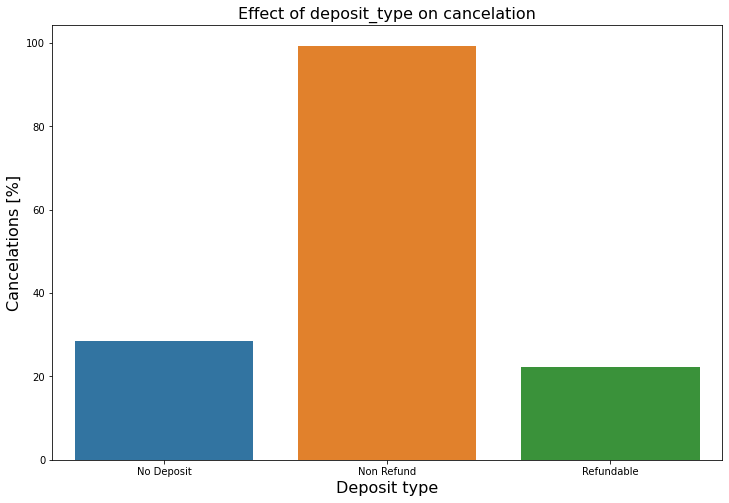

In [51]:
# group data for deposit_type:
deposit_cancel_data = df_cln.groupby("deposit_type")["is_canceled"].describe()

#show figure:
plt.figure(figsize=(12, 8))
sns.barplot(x=deposit_cancel_data.index, y=deposit_cancel_data["mean"] * 100)
plt.title("Effect of deposit_type on cancelation", fontsize=16)
plt.xlabel("Deposit type", fontsize=16)
plt.ylabel("Cancelations [%]", fontsize=16)
plt.show()

As Susmit Vengurlekar already pointed out in the Discussion section of the dataset, the deposit_type 'Non Refund' and the 'is_canceled' column are correlated in a counter-intuitive way.

Over 99 % of people who paid the entire amount upfront canceled. This raises the question if there is something wrong with the data (or the description).

What else stands out for Non Refund deposits?

Here is a table of all mean values of the data, grouped by deposit type:

In [52]:
deposit_mean_data = df_cln.groupby("deposit_type").mean()
deposit_mean_data

is_canceled   lead_time  arrival_date_year  \
deposit_type                                               
No Deposit       0.284020   88.841951        2016.173950   
Non Refund       0.993624  212.908891        2016.031466   
Refundable       0.222222  152.098765        2016.141975   

              arrival_date_week_number  arrival_date_day_of_month  \
deposit_type                                                        
No Deposit                   27.133208                  15.815223   
Non Refund                   27.448619                  15.595462   
Refundable                   20.932099                  23.456790   

              stays_in_weekend_nights  stays_in_week_nights    adults  \
deposit_type                                                            
No Deposit                   0.969615              2.555633  1.865806   
Non Refund                   0.621718              2.091109  1.811407   
Refundable                   0.975309              2.851852  1.907407   

              children    babies  ...      agent     company  \
deposit_type                      ...                          
No Deposit    0.118599  0.009085  ...  78.745503   11.175874   
Non Refund    0.000617  0.000000  ...  47.480016    6.215809   
Refundable    0.030864  0.000000  ...  56.185185  133.666667   

              days_in_waiting_list         adr  required_car_parking_spaces  \
deposit_type                                                                  
No Deposit                1.518040  103.685436                     0.071184   
Non Refund                7.992253   89.964017                     0.000069   
Refundable                9.586420   76.209753                     0.123457   

              total_of_special_requests     adr_pp         year     month  \
deposit_type                                                                
No Deposit                     0.651726  55.231806  2016.150554  6.322034   
Non Refund                     0.001782  54.520286  2015.685062  6.426818   
Refundable                     0.141975  41.444239  2016.117284  5.419753   

                    day  
deposit_type             
No Deposit    15.750337  
Non Refund    15.111743  
Refundable    11.395062  

[3 rows x 24 columns]

Comparing the mean values for Non refund to No Deposit shows the following:

- Non Refund deposits are characterized by > 2x longer lead_time
- is_repeated_guest is ~ 1/10th
- previous_cancellations is 10x higher
- previous_bookings_not_canceled is 1/15th
- required_car_parking_spaces is almost zero
- special requests are very rare
- Based on these findings it seems that especially people who have not previosly visited one of the hotels book, pay and cancel repeatedly... this is strange!

To adress this issue, I will make a model without this feature below.

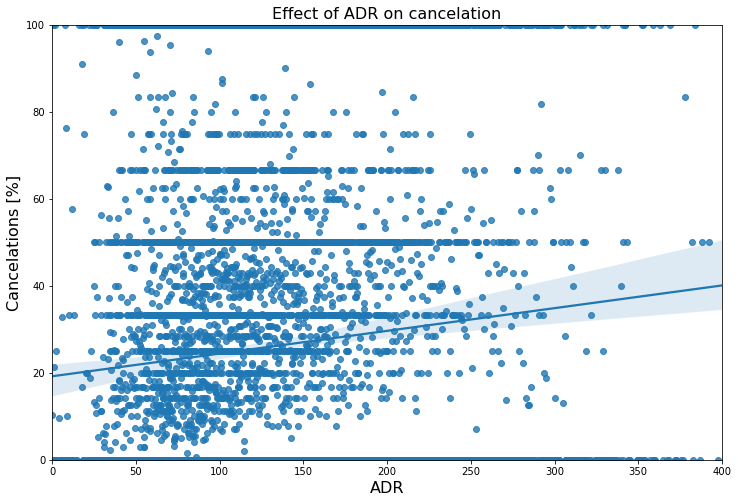

In [53]:
# group data for adr:
adr_cancel_data = df_cln.groupby("adr")["is_canceled"].describe()
#show figure:
plt.figure(figsize=(12, 8))
sns.regplot(x=adr_cancel_data.index, y=adr_cancel_data["mean"].values * 100)
plt.title("Effect of ADR on cancelation", fontsize=16)
plt.xlabel("ADR", fontsize=16)
plt.ylabel("Cancelations [%]", fontsize=16)
plt.xlim(0,400)
plt.ylim(0,100)
plt.show()

## RF model without deposit type:

In [55]:
cat_features_non_dep = ["hotel",'arrival_date_month', "meal","market_segment",
                "distribution_channel","reserved_room_type","customer_type"]

features_non_dep = num_features + cat_features_non_dep
#X_non_dep = df_cln.drop(["is_canceled"], axis=1)[features_non_dep]
X_non_dep = X[features_non_dep]

In [56]:
# Bundle preprocessing for numerical and categorical features:
preprocessor_non_dep = ColumnTransformer(transformers=[("num", num_transformer, num_features),
                                               ("cat", cat_transformer, cat_features_non_dep)])

# Define dataset:
#X_non_dep = df.drop(["is_canceled"], axis=1)[features_non_dep]
# Define model
rf_model_non_dep = RandomForestClassifier(random_state=42) # basic model for this purpose

kfolds=4
split = KFold(n_splits=kfolds, shuffle=True, random_state=42)
model_pipe = Pipeline(steps=[('preprocessor', preprocessor_non_dep),
                              ('model', rf_model_non_dep)])
cv_results = cross_val_score(model_pipe, 
                                 X_non_dep, y, 
                                 cv=split,
                                 scoring="accuracy",
                                 n_jobs=-1)
# output:
min_score = round(min(cv_results), 4)
max_score = round(max(cv_results), 4)
mean_score = round(np.mean(cv_results), 4)
std_dev = round(np.std(cv_results), 4)
print(f"RF model without deposit_type feature cross validation accuarcy score: {mean_score} +/- {std_dev} (std) min: {min_score}, max: {max_score}")

RF model without deposit_type feature cross validation accuarcy score: 0.8662 +/- 0.0006 (std) min: 0.8654, max: 0.8671


## Feature Importance Using eli5

In [57]:
# feat importance of original model:
feat_imp_df.head(10)

feature    weight       std
0                  lead_time  0.146662  0.015429
1    deposit_type_Non Refund  0.144410  0.104293
2                        adr  0.095883  0.003540
3  arrival_date_day_of_month  0.069530  0.002063
4    deposit_type_No Deposit  0.068087  0.099340
5   arrival_date_week_number  0.053693  0.002527
6  total_of_special_requests  0.050826  0.011110
7                      agent  0.042553  0.005336
8       stays_in_week_nights  0.041500  0.002232
9     previous_cancellations  0.040826  0.014164

In [58]:
# Check feature importance of new model:
# fit model(pipeline) so values can be accessed:
model_pipe.fit(X_non_dep,y)

# Names of all (encoded) features are needed.
# Get names of columns from One Hot Encoding:
onehot_columns = list(model_pipe.named_steps['preprocessor'].
                      named_transformers_['cat'].
                      named_steps['onehot'].
                      get_feature_names(input_features=cat_features_non_dep))

# Add num_features for full list.
# Order must be as in definition of X, where num_features are first: 
feat_imp_list = num_features + onehot_columns

# show 10 most important features, provide names of features:
feat_imp_df_non_dep = eli5.formatters.as_dataframe.explain_weights_df(
    model_pipe.named_steps['model'],
    feature_names=feat_imp_list)

In [59]:
# feat importance of new model:
feat_imp_df_non_dep.head(10)

feature    weight       std
0                  lead_time  0.172700  0.020033
1                        adr  0.111006  0.006795
2  total_of_special_requests  0.077629  0.012427
3  arrival_date_day_of_month  0.076399  0.002958
4   arrival_date_week_number  0.060364  0.003916
5                      agent  0.053749  0.009322
6       stays_in_week_nights  0.049094  0.003966
7     previous_cancellations  0.048949  0.016884
8    stays_in_weekend_nights  0.030984  0.002859
9    customer_type_Transient  0.029824  0.019587

The new accuracy score of 0.8653 is almost identical to the one obtained with the deposit_type included (0.8664),
which placed significant wheight on this feature.
The new model compensated this by placing increased weight on lead_time, adr, total_of_special_requests and others.

# Feature Importance - OneHotEncoder

## Extratree Regression

In [60]:
train_x_num = df_cln[num_features]
train_x_cat = df_cln[cat_features]

In [61]:
train_y = df_cln['is_canceled']

In [62]:
#One-Hot Encoding for categorical features

#train_x_cat_enc = train_x_cat.apply(OneHotEncoder(handle_unknown = 'ignore').fit_transform)
enc = OneHotEncoder(handle_unknown = 'ignore')
cat_enc = enc.fit(train_x_cat)
train_x_cat_enc = cat_enc.transform(train_x_cat).toarray()

In [63]:
#Combine the feature names names num + cat
feature_name = np.concatenate((train_x_num.columns.values, cat_enc.get_feature_names()))

#Combine the features num + cat
train_x = np.concatenate((train_x_num, train_x_cat_enc), axis = 1)

In [64]:
df_cln_updated = pd.DataFrame(train_x, columns = feature_name)

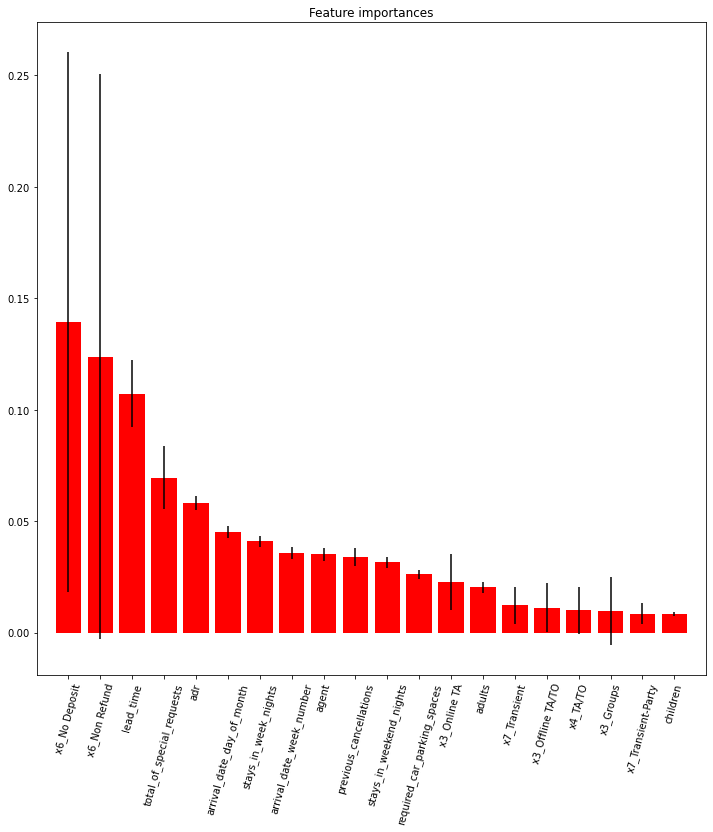

In [65]:
from sklearn import ensemble 

model = ensemble.ExtraTreesRegressor(n_estimators=25, max_depth=30, max_features=0.3, n_jobs=-1, random_state=0)
model.fit(train_x, train_y)

#plot imp 
importance = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_],axis=0)
indices = np.argsort(importance)[::-1][:20]

plt.figure(figsize=(12,12))
plt.title("Feature importances")
plt.bar(range(len(indices)), importance[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(len(indices)), feature_name[indices], rotation='75')
plt.xlim([-1, len(indices)])
plt.show()

## Feature Importance xgb

[14:15:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[14:15:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




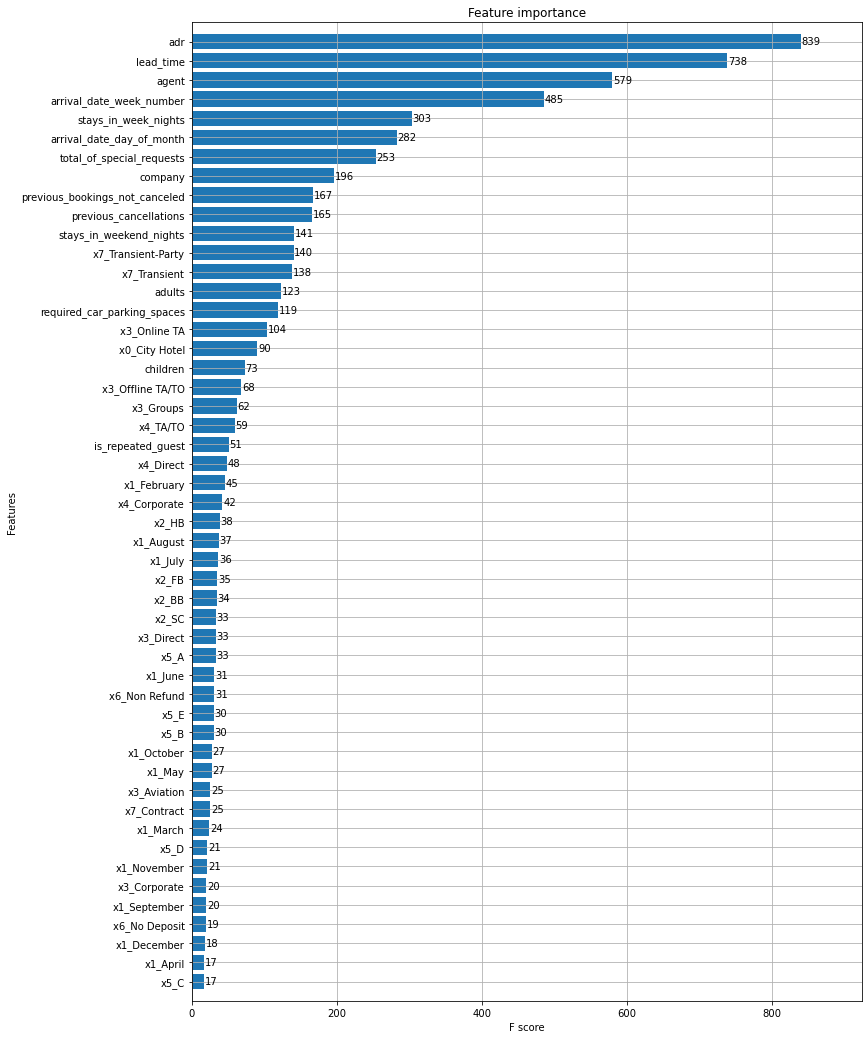

In [66]:
import xgboost as xgb 

xgb_prames = {
    'eta': 0.05,
    'max_depth': 8,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'silent': 1,
    'seed' : 0
}

dtrain = xgb.DMatrix(train_x,train_y, feature_names=feature_name)

model = xgb.train(dict(xgb_prames, silent=0), dtrain, num_boost_round=50)


fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

# Train the model using selected features

In [67]:
select_feature = ['adr', 'lead_time', 'agent', 'arrival_date_week_number', 'stays_in_week_nights', 'arrival_date_day_of_month', 'total_of_special_requests']

In [68]:
# Define dataset:
X_select = df_cln_updated[select_feature]
y_select = df_cln['is_canceled']
# Define model
rf_model_non_dep = RandomForestClassifier(n_estimators=160,
                               max_features=0.4,
                               min_samples_split=2,
                               n_jobs=-1,
                               random_state=0)

kfolds=4
split = KFold(n_splits=kfolds, shuffle=True, random_state=42)

cv_results = cross_val_score(rf_model_non_dep, 
                                 X_select, y_select, 
                                 cv=split,
                                 scoring="accuracy",
                                 n_jobs=-1)
# output:
min_score = round(min(cv_results), 4)
max_score = round(max(cv_results), 4)
mean_score = round(np.mean(cv_results), 4)
std_dev = round(np.std(cv_results), 4)
print(f"RF model without deposit_type feature cross validation accuarcy score: {mean_score} +/- {std_dev} (std) min: {min_score}, max: {max_score}")

RF model without deposit_type feature cross validation accuarcy score: 0.8511 +/- 0.0018 (std) min: 0.8489, max: 0.8536


# Try Label Encode

# Extratree Regression

In [69]:
#One-Hot Encoding for categorical features
train_x_cat_enc_label = train_x_cat.apply(LabelEncoder().fit_transform)

In [70]:
train_x_label = pd.concat((train_x_num, train_x_cat_enc_label), axis = 1)

In [71]:
train_x_label.shape

(119210, 24)

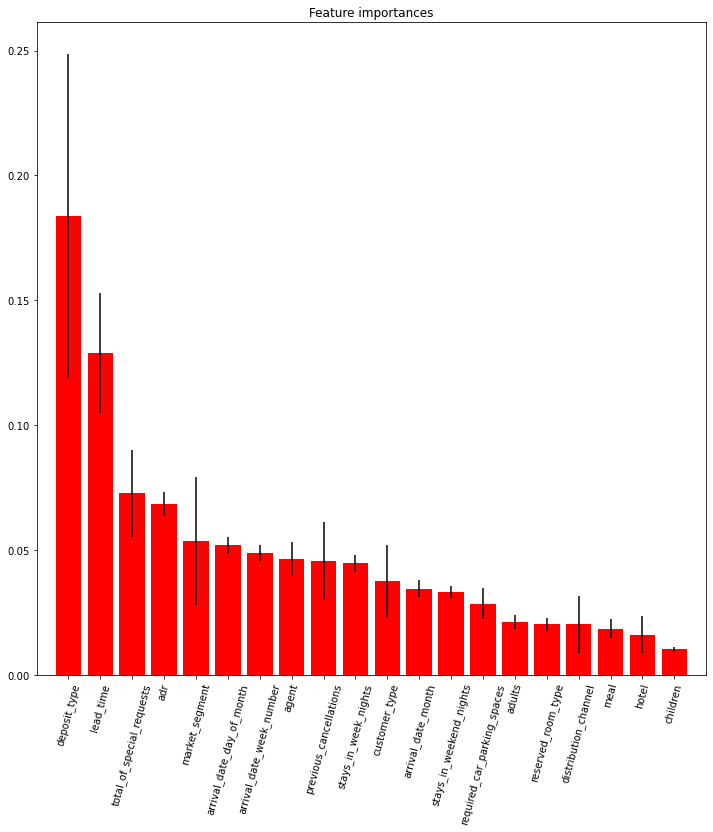

In [72]:
model = ensemble.ExtraTreesRegressor(n_estimators=25, max_depth=30, max_features=0.3, n_jobs=-1, random_state=0)
model.fit(train_x_label, train_y)

#plot imp 
importance = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_],axis=0)
indices = np.argsort(importance)[::-1][:20]

plt.figure(figsize=(12,12))
plt.title("Feature importances")
plt.bar(range(len(indices)), importance[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(len(indices)), train_x_label.columns.values[indices], rotation='75')
plt.xlim([-1, len(indices)])
plt.show()

## Feature Importance xgb

[14:15:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[14:15:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




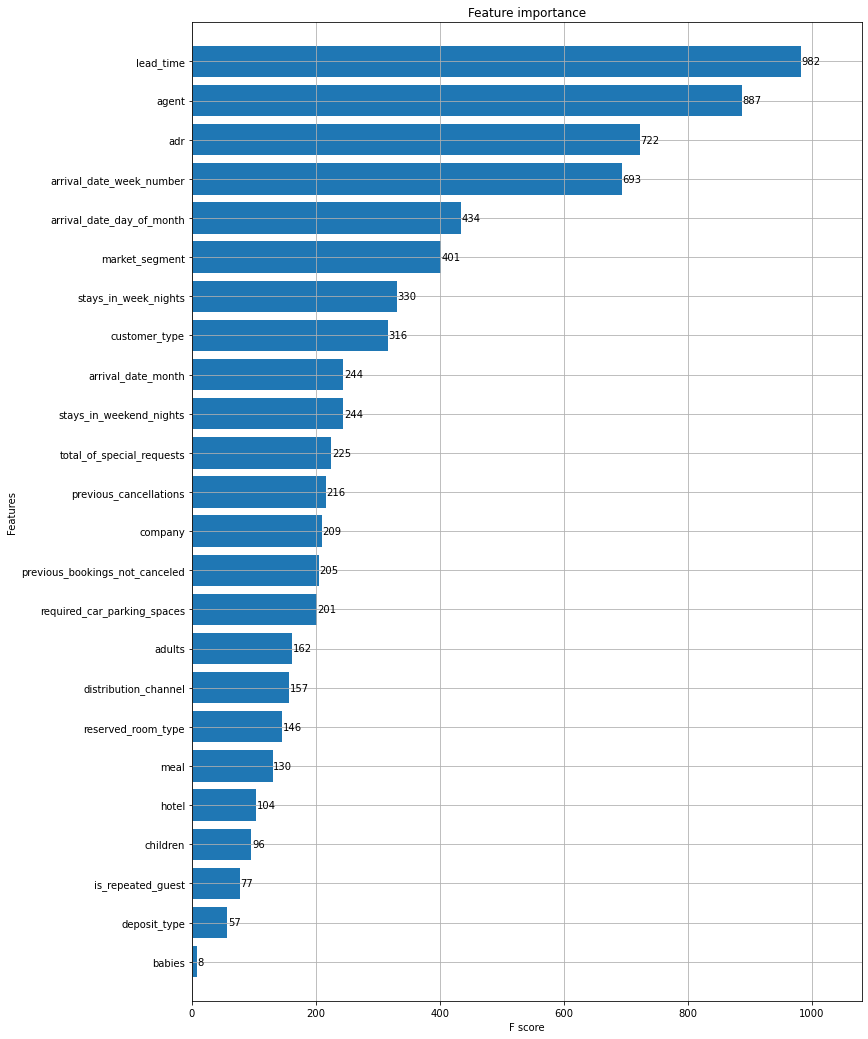

In [73]:
xgb_prames = {
    'eta': 0.05,
    'max_depth': 8,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'silent': 1,
    'seed' : 0
}

dtrain = xgb.DMatrix(train_x_label,train_y, feature_names=train_x_label.columns.values)

model = xgb.train(dict(xgb_prames, silent=0), dtrain, num_boost_round=50)


fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

## Normalizing Numerical Variables

In [74]:
normalize_cat = ['lead_time', 'arrival_date_week_number', 'arrival_date_day_of_month', 'agent', 'company', 'adr']

train_x_norm = train_x_label.copy()

In [75]:
train_x_norm[num_features].var()

lead_time                         11422.361808
arrival_date_week_number            184.990111
arrival_date_day_of_month            77.107192
stays_in_weekend_nights               0.990258
stays_in_week_nights                  3.599010
adults                                0.330838
children                              0.159070
babies                                0.009508
is_repeated_guest                     0.030507
previous_cancellations                0.713887
previous_bookings_not_canceled        2.244415
agent                             11485.169679
company                            2897.684308
required_car_parking_spaces           0.060201
total_of_special_requests             0.628652
adr                                2543.589039
dtype: float64

Consider log normalizing as the variance difference is huge

In [76]:
for cat in normalize_cat:
    train_x_norm[cat] = np.log(train_x_label[cat] + 1)

C:\Users\frank\Anaconda3\envs\pytorch\lib\site-packages\pandas\core\series.py:679: RuntimeWarning:

invalid value encountered in log



In [77]:
train_x_norm[num_features].var()

lead_time                         2.582757
arrival_date_week_number          0.440884
arrival_date_day_of_month         0.506325
stays_in_weekend_nights           0.990258
stays_in_week_nights              3.599010
adults                            0.330838
children                          0.159070
babies                            0.009508
is_repeated_guest                 0.030507
previous_cancellations            0.713887
previous_bookings_not_canceled    2.244415
agent                             3.535793
company                           1.346883
required_car_parking_spaces       0.060201
total_of_special_requests         0.628652
adr                               0.515480
dtype: float64

Variance Differences were reduced

In [78]:
train_x_norm[normalize_cat].isnull().sum()

lead_time                    0
arrival_date_week_number     0
arrival_date_day_of_month    0
agent                        0
company                      0
adr                          1
dtype: int64

In [79]:
train_x_norm['adr'] = train_x_norm['adr'].fillna(value = train_x_norm['adr'].mean())

In [80]:
train_x_norm[cat_features]

hotel  arrival_date_month  meal  market_segment  distribution_channel  \
0           1                   5     0               3                     1   
1           1                   5     0               3                     1   
2           1                   5     0               3                     1   
3           1                   5     0               2                     0   
4           1                   5     0               6                     3   
...       ...                 ...   ...             ...                   ...   
119205      0                   1     0               5                     3   
119206      0                   1     0               6                     3   
119207      0                   1     0               6                     3   
119208      0                   1     0               6                     3   
119209      0                   1     2               6                     3   

        reserved_room_type  deposit_type  customer_type  
0                        2             0              2  
1                        2             0              2  
2                        0             0              2  
3                        0             0              2  
4                        0             0              2  
...                    ...           ...            ...  
119205                   0             0              2  
119206                   4             0              2  
119207                   3             0              2  
119208                   0             0              2  
119209                   0             0              2  

[119210 rows x 8 columns]

# Classification Model Building

In [81]:
lr = LogisticRegression() #LogisticRegression
knn = KNeighborsClassifier() #KNN
dtc = DecisionTreeClassifier() #Decision Tree
rd_clf = RandomForestClassifier() #Random Forester
ada = AdaBoostClassifier(base_estimator = dtc) #AdaBoost with decision tree classifier
gb = GradientBoostingClassifier() #GradientBoosting
xgb = XGBClassifier(booster = 'gbtree', learning_rate = 0.1, max_depth = 5, n_estimators = 180) #XgBoost Classifier
cat = CatBoostClassifier(iterations=100) #Cat Boost Classifier
etc = ExtraTreesClassifier() #Extra Trees Classfier
lgbm = LGBMClassifier(learning_rate = 1) #LGBM Classifier

#Voting Classifier
classifiers = [('Gradient Boosting Classifier', gb), ('Cat Boost Classifier', cat), ('XGboost', xgb),  ('Decision Tree', dtc),
               ('Extra Tree', etc), ('Light Gradient', lgbm), ('Random Forest', rd_clf), ('Ada Boost', ada), ('Logistic', lr),
               ('Knn', knn)]
vc = VotingClassifier(estimators = classifiers)

In [82]:
model_list = {'logistic regression' : lr, 'knn' : knn, 'Decision Tree' : dtc, 'Random Forester' : rd_clf, 'AdaBoost' : ada,
              'Gradient Boosting' : gb, 'XgBoost' : xgb, 'Cat Boost' : cat, 'Extra Tree Classifier' : etc, 'LGBM Classifier' : lgbm}

In [83]:
X_train, X_test, y_train, y_test = train_test_split(train_x_norm, train_y, test_size = 0.3, shuffle = True, random_state = 7)
#X_train, X_test, y_train, y_test = train_test_split(train_x_norm, train_y, test_size = 0.3, shuffle = False, random_state = 7)

In [84]:
from collections import defaultdict

pred_results = defaultdict(list)

for name, model in model_list.items():
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    conf = confusion_matrix(y_test, y_pred)
    clf_report = classification_report(y_test, y_pred)
    
    pred_results['acc'].append(acc)
    pred_results['conf'].append(conf)
    #clf_report['clf'].append(clf_report)
    
    

C:\Users\frank\Anaconda3\envs\pytorch\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\frank\Anaconda3\envs\pytorch\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[14:17:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Learning rate set to 0.5
0:	learn: 0.4669385	total: 224ms	remaining: 22.2s
1:	learn: 0.4240581	total: 244ms	remaining: 12s
2:	learn: 0.4115958	total: 258ms	remaining: 8.34s
3:	learn: 0.4038862	total: 270ms	remaining: 6.47s
4:	learn: 0.4005757	total: 280ms	remaining: 5.33s
5:	learn: 0.3964503	total: 291ms	remaining: 4.57s
6:	learn: 0.3945470	total: 302ms	remaining: 4.01s
7:	learn: 0.3929443	total: 313ms	remaining: 3.6s
8:	learn: 0.3902548	total: 325ms	remaining: 3.29s
9:	learn: 0.3896511	total: 336ms	remaining: 3.02s
10:	learn: 0.3871336	total: 346ms	remaining: 2.8s
11:	learn: 0.3847212	total: 358ms	remaining: 2.63s
12:	learn: 0.3832931	total: 370ms	remaining: 2.47s
13:	learn: 0.381

In [85]:
df_acc = pd.DataFrame(pred_results['acc'], index = model_list.keys(), columns = ['accuracy'])

In [86]:
df_acc

accuracy
logistic regression    0.799402
knn                    0.811929
Decision Tree          0.822442
Random Forester        0.865503
AdaBoost               0.834773
Gradient Boosting      0.818919
XgBoost                0.836144
Cat Boost              0.841121
Extra Tree Classifier  0.861701
LGBM Classifier        0.831082

In [87]:
#Confusion Matrix for XgBoost and Cat Boost

pred_results['conf'][6:8]

[array([[21066,  1414],
        [ 4446,  8837]], dtype=int64),
 array([[20784,  1696],
        [ 3986,  9297]], dtype=int64)]

## ANN

In [88]:
from tensorflow.keras.utils import to_categorical

y_test = to_categorical(y_test)
y_train = to_categorical(y_train)

In [94]:
import keras
from keras.layers import Dense
from keras.models import Sequential

model  = Sequential()
model.add(Dense(100, activation = 'relu', input_shape = (24, )))
model.add(Dense(100, activation = 'relu'))
model.add(Dense(2, activation = 'sigmoid'))
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model_history = model.fit(X_train, y_train, validation_data = (X_test, y_test),
                          epochs = 40)

Epoch 1/40
2608/2608 [==============================] - 3s 885us/step - loss: 0.4881 - accuracy: 0.7595 - val_loss: 0.4313 - val_accuracy: 0.7870
Epoch 2/40
2608/2608 [==============================] - 2s 799us/step - loss: 0.4220 - accuracy: 0.8027 - val_loss: 0.4083 - val_accuracy: 0.8108
Epoch 3/40
2608/2608 [==============================] - 2s 791us/step - loss: 0.4098 - accuracy: 0.8079 - val_loss: 0.3996 - val_accuracy: 0.8153
Epoch 4/40
2608/2608 [==============================] - 2s 800us/step - loss: 0.3999 - accuracy: 0.8129 - val_loss: 0.3953 - val_accuracy: 0.8133
Epoch 5/40
2608/2608 [==============================] - 2s 794us/step - loss: 0.3958 - accuracy: 0.8146 - val_loss: 0.3947 - val_accuracy: 0.8142
Epoch 6/40
2608/2608 [==============================] - 2s 796us/step - loss: 0.3909 - accuracy: 0.8164 - val_loss: 0.3882 - val_accuracy: 0.8190
Epoch 7/40
2608/2608 [==============================] - 2s 802us/step - loss: 0.3856 - accuracy: 0.8201 - val_loss: 0.3841 -

<AxesSubplot:>

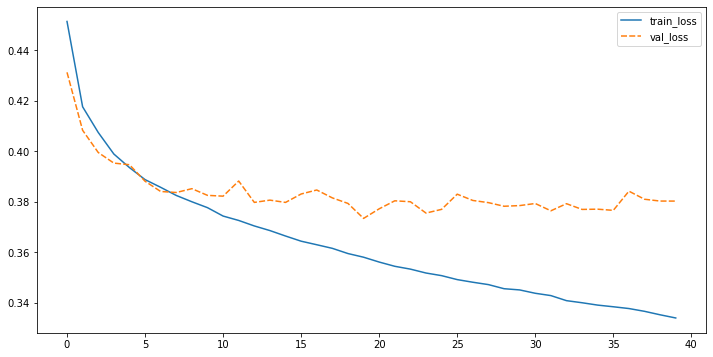

In [95]:
plt.figure(figsize = (12, 6))

train_loss = model_history.history['loss']
val_loss = model_history.history['val_loss'] 
epoch = range(1, 101)

loss = pd.DataFrame({'train_loss' : train_loss, 'val_loss' : val_loss})

sns.lineplot(data = loss)

<AxesSubplot:>

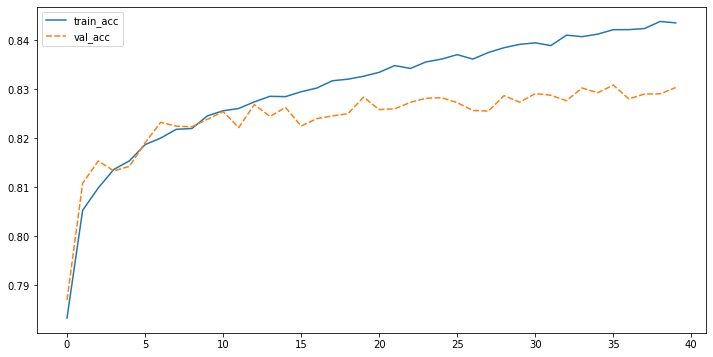

In [96]:
plt.figure(figsize = (12, 6))

train_acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy'] 
epoch = range(1, 101)


accuracy = pd.DataFrame({'train_acc' : train_acc, 'val_acc' : val_acc})

sns.lineplot(data = accuracy)

In [97]:
acc_ann = model.evaluate(X_test, y_test)[1]

print(f'Accuracy of model is {acc_ann}')

1118/1118 [==============================] - 1s 472us/step - loss: 0.3803 - accuracy: 0.8303
Accuracy of model is 0.8303274512290955
